<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/HDattempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.manual_seed(0)
dtype = torch.float
from google.colab import drive
drive.mount('/content/drive/')
import zipfile
import sys
sys.path.append('local_modules')
!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



In [0]:
import numpy as np
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader

net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/HD/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 20

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X,y = next(train_loader)

In [10]:


class HD_Net(utils.Net): 
  def __init__(self):
    super().__init__()
  def forward(self, X):
    batch_size = len(X)
    final_output = torch.empty(batch_size, 2)
    
    max_score_1 = -1e9*torch.ones(batch_size)
    for i in range(19): 
      for j in range(19): 
        s_image = X[:,:,i*50:i*50+100, j*60:j*60+120]
        input_ = s_image.reshape(-1, 3, 100, 120) # This shape is necessary for the network 
        output = net(input_)
        _, predicted = torch.max(output.data, 1)
        
        
        score_class_1 = output.data[:,1]
        greater = (score_class_1 > max_score_1)
        max_score_1[greater] = score_class_1[greater]
        final_output[greater] = output[greater]
    return final_output

HDN = HD_Net()
correct = 0

output = HDN(X)
_, predicted = torch.max(output.data, 1)
  
print("Correct: %f percent." % (100*(predicted == y).sum()/len(y)))


Correct: 100.000000 percent.


tensor(-3.6712) tensor(-1.0000e+09)
tensor(-4.8271) tensor(-3.6712)
tensor(-5.1757) tensor(-3.6712)
tensor(-3.9611) tensor(-3.6712)
tensor(-6.5893) tensor(-3.6712)
tensor(-4.8889) tensor(-3.6712)
tensor(-6.0776) tensor(-3.6712)
tensor(-6.1938) tensor(-3.6712)
tensor(-5.0632) tensor(-3.6712)
tensor(-4.6497) tensor(-3.6712)
tensor(-4.5617) tensor(-3.6712)
tensor(-6.8280) tensor(-3.6712)
tensor(-7.4661) tensor(-3.6712)
tensor(-5.2670) tensor(-3.6712)
tensor(-4.4352) tensor(-3.6712)
tensor(-5.4919) tensor(-3.6712)
tensor(-4.8728) tensor(-3.6712)
tensor(-7.8109) tensor(-3.6712)
tensor(-5.5265) tensor(-3.6712)
tensor(-7.0508) tensor(-3.6712)
tensor(-3.7612) tensor(-3.6712)
tensor(-6.8681) tensor(-3.6712)
tensor(5.5920) tensor(-3.6712)
tensor(5.2079) tensor(5.5920)
tensor(-4.0930) tensor(5.5920)
tensor(-4.5272) tensor(5.5920)
tensor(-6.6145) tensor(5.5920)
tensor(-6.6570) tensor(5.5920)
tensor(-5.0656) tensor(5.5920)
tensor(-3.4772) tensor(5.5920)
tensor(-7.1316) tensor(5.5920)
tensor(-4.3011

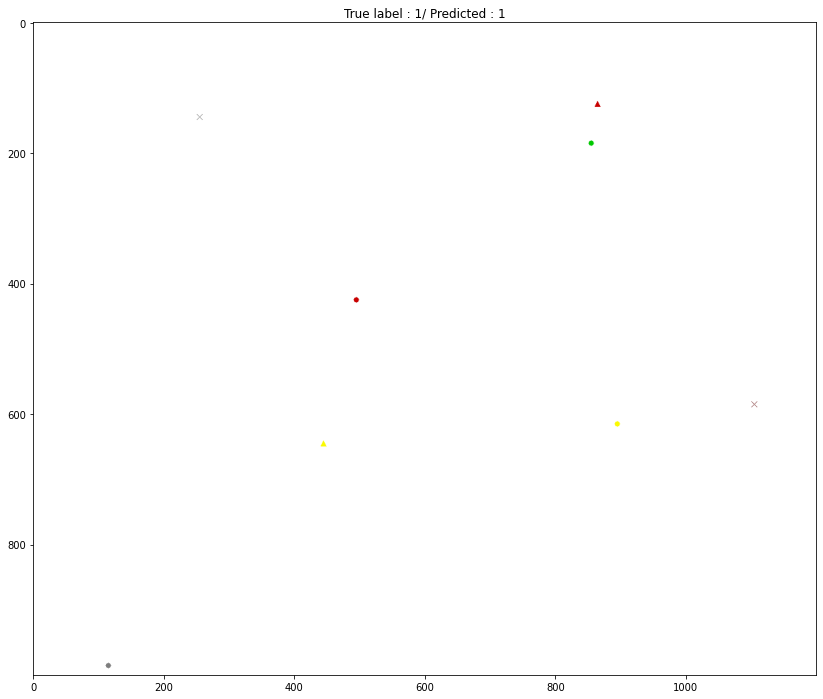

In [6]:
i = 19
image0 = X[i]
label0 = y[i]

input0 = X[i].unsqueeze(0)
output0 = HDN(input0)
_, predicted0 = torch.max(output0.data, 1)
print(predicted0)



img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0), figure_size = (16,12))

## SHAP


In [5]:
!pip install shap 
import shap

# For SHAP
bg_choice = "black" # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(HDN, background)

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=c553bd7f5bf6e2009b0d2c97aa70d23173df1c9d3c80195d3d76a8846723b81e
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

intp.shap_exp(e, input0.detach(), img0)

     |████████████████████████████████| 6.0MB 2.6MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=2eacf43182ed9d4347994680ef187f965374b14743a45369b99e3639974f6f29
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam
--2020-03-31 18:11:33--  https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3229 (3.2K) [text/plain]
Saving to: ‘local_modules/interpret11.py’

interpret11.py      100%[===================>]   3.15K  --.-KB/s    in 0s      

2020-03-31 18:11:33 (64.5 MB/s) - ‘local_modules/interpret11.py’ saved [3229/3229]



pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


## Hierarchical Shapley

In [11]:
# For Hierarchical 
!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley13.py -P local_modules -nc
import local_modules.Hshapley13 as HS

white_bg = torch.ones(X.shape[1:])
h = HS.HierarchicalShap(HDN, background = white_bg)

File ‘local_modules/Hshapley13.py’ already there; not retrieving.



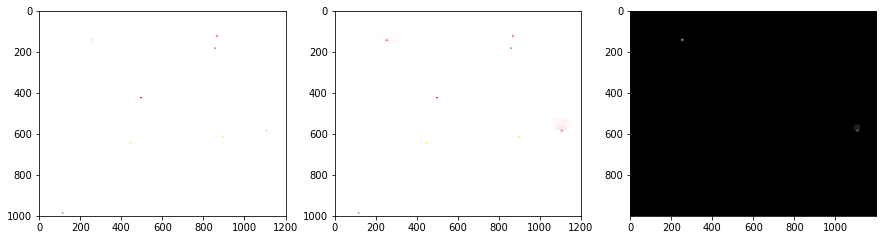

In [16]:
h.shapMap(X[i], y[i], shapTol = [6], keepItSimple = False, debug = False)
